In [1]:
from sim_core.engine import Engine
from sim_core.car import Car
from sim_core.autoTransmission import AutoTransmission
from sim_core.utils import ms_to_kph, example_torque_curve

engine = Engine(
    ratio_gears=[3.5, 2.8, 2.1, 1.7, 1.3, 1],
    ratio_differential=4,
    torque_output = example_torque_curve,
    max_rpm=10000,
    min_rpm=500,
    idle_rpm=2000
)

car = Car(
    mass=700,
    radius_wheel=0.3,
    engine=engine
)

auto_transmission = AutoTransmission(
    car.engine,
    8000,
    3000
)

In [35]:
class Compound:
    def __init__(self, base_grip, degradation_rate, degradation_rate_change):
        self.base_grip = base_grip
        self.degradation_rate = degradation_rate
        self.degradation_rate_change = degradation_rate_change

class Tire:
    def __init__(self, compound, age):
        self.compound = compound
        self.age = age

    def get_grip(self):
        return max(0, self.compound.base_grip - (self.compound.degradation_rate * self.age + 0.5 * self.compound.degradation_rate_change * self.age ** 2))

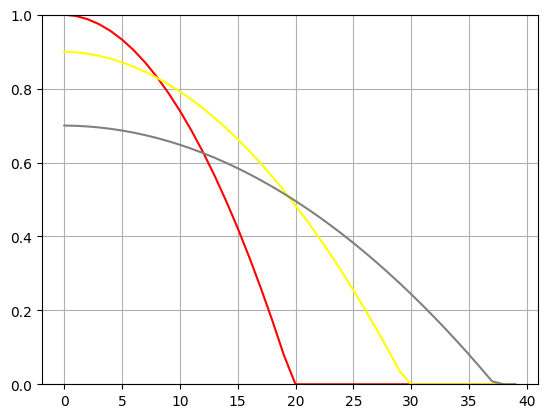

In [43]:
soft = Compound(1, 0.001, 0.005)
medium = Compound(0.9, 0.0008, 0.002)
hard = Compound(0.7, 0.0002, 0.001)

tire = Tire(soft, 0)
tire2 = Tire(medium, 0)
tire3 = Tire(hard, 0)

tire.age = 0
tire2.age = 0
tire3.age = 0

grips_soft = []
grips_med = []
grips_hard = []

for i in range(40):
    grips_soft.append(tire.get_grip())
    grips_med.append(tire2.get_grip())
    grips_hard.append(tire3.get_grip())
    #print(f'Tire age : {tire.age}, grip : {tire.get_grip()}, usage percent {tire.get_grip() / tire.compound.base_grip * 100}%')
    tire.age += 1
    tire2.age += 1
    tire3.age += 1

import matplotlib.pyplot as plt

fig, ax = plt.subplots()

ax.plot(grips_soft, color='red')
ax.plot(grips_med, color='yellow')
ax.plot(grips_hard, color='gray')
ax.set_ylim([0, 1])
ax.grid()